# Third experiment
## Convolutional neural network (alexnet), mnist


In this experiment we are going to test the robustness of neural networks in a very basic configuration, using Activation Function in the hidden layer as a changing parameter.
The constant characteristics of the networks are:
* Dataset = fashon_mnist
* Loss = cathegorical crossentropy
* Output activation = softmax
* Number of hidden layers = 1
* Early stopping metric =  val_loss with patience 10

After having our models correctly set up, we are going to attack them and measure their robustness according to some metrics (before and after attack):
* Accuracy
* Precision
* Recall
* Max and min confidence
* Confusion matrix
* Most and least robust class


## Imports

In [1]:
from debugpy.server.attach_pid_injected import attach

from functions import *
# plt.rcParams["figure.figsize"] = (20, 10)
import time
import gc
from PIL import Image
import glob
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Model

### Data Load and Preprocessing

In [2]:
# load data
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train set: ", train_images.shape)
print("Test set: ", test_images.shape)

# divide data into classes
subsets = []
n_classes = 10
for i in range(n_classes):
    tmp_list = []
    for j in range(test_images.shape[0]):
        c = np.nonzero(test_labels[j])[0][0]
        if c == i:
            tmp_list.append(test_images[j])
    tmp_list = np.array(tmp_list)
    subsets.append(tmp_list)
# now we have subsets which is a 10-elements list containing arrays of same class images

new_test_images = np.zeros((0,28,28))
for i in range(len(subsets)):
    new_test_images = np.concatenate((new_test_images, subsets[i]))
# now we have new_test_images which is test_images sorted by class

new_test_labels = np.zeros((0,10))
for i in range(len(subsets)):
    tmp = np.zeros((subsets[i].shape[0],10))
    tmp[:,i] = 1
    new_test_labels = np.concatenate((new_test_labels, tmp))
# now we have new_test_labels which is test_labels sorted to fit subsets

Train set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


### Build and Train Models

In [ ]:

x = tf.reshape(train_images, shape=[-1, 28, 28, 1])

for function, initializer in DEEP_ACTIVATION.items():

    network = models.Sequential()

    #1st Convolutional Layer
    network.add(layers.Conv2D(filters=96, input_shape=(28,28,1), kernel_size=(3,3), strides=(1,1), padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    network.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    network.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    network.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    network.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))

    #4th Convolutional Layer
    network.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))

    #5th Convolutional Layer
    network.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    network.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    network.add(layers.Flatten())
    # 1st Fully Connected Layer
    network.add(layers.Dense(512, input_shape=(28,28,1,)))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    # Add Dropout to prevent overfitting
    network.add(layers.Dropout(0.4))

    #2nd Fully Connected Layer
    network.add(layers.Dense(512))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    #Add Dropout
    network.add(layers.Dropout(0.4))

    #3rd Fully Connected Layer
    network.add(layers.Dense(512))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('relu'))
    #Add Dropout
    network.add(layers.Dropout(0.4))

    #Output Layer
    network.add(layers.Dense(10))
    network.add(layers.BatchNormalization())
    network.add(layers.Activation('softmax'))

    #Model Summary
    network.summary()

    network.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

    print(f'Network training with ativation function = "{function}"')

    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)
    path = MODELS_PATH+"/best_" + function + ".h5"
    mc = ModelCheckpoint(filepath=path, monitor="val_loss", mode="min", save_best_only=True)
    cb_list = [es, mc]

    h = network.fit(x,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT,callbacks=cb_list)

    # At this point we have best models saved in "best_models" folder

### Model Metrics Evaluation

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    print(f'Evaluate model with hidden activation function "{function}"...')
    name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(name)
    metrics_name = "scores_best_"+function
    x = tf.reshape(new_test_images, shape=[-1, 28, 28, 1])
    m = ModelMetrics(metrics_name, new_test_images, new_test_labels, model.predict(x))
    m.buil_metrics()
    path = SCORES_PATH+"/"+metrics_name
    save_object(m, path)

Evaluate model with hidden activation function "sigmoid"...
Evaluate model with hidden activation function "tanh"...
Evaluate model with hidden activation function "relu"...
Evaluate model with hidden activation function "selu"...
Evaluate model with hidden activation function "elu"...
Evaluate model with hidden activation function "exponential"...
Evaluate model with hidden activation function "swish"...


## Attack

The attack consists of these steps:
1. select the model
2. take the test set and, for each class, find the most vulnerable pixel and the corresponding value (i.e. x,y,z)
3. modify the entire test set changing the pixel values found in the previous step
4. evaluate all the metrics of the selected model with the modified test set


### Prepare Attack

In [6]:
def objective(trial, m, test, current_class):

    xp = trial.suggest_int("xp", MIN_XP, MAX_XP)
    yp = trial.suggest_int("yp", MIN_YP, MAX_XP)
    value = trial.suggest_uniform("zp", MIN_ZP, MAX_ZP)

    new_test_labels = np.zeros((test.shape[0],10))
    new_test_labels[:,current_class] = 1

    tmp = np.copy(test)
    tmp[:,xp,yp] = value
    x = tf.reshape(tmp, shape=[-1, 28, 28, 1])

    # minimize loss

    return m.evaluate(x,new_test_labels, verbose=0)[1]

def print_best_callback(study, trial):
    print(f"#Trial: {trial.number}, Best value: {study.best_value}, Best params: {study.best_trial.params}")

### Perform Attack

In [7]:
start_time = time.time()

for function, initializer in DEEP_ACTIVATION.items(): # 7
    model_name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(model_name)
    new_attacked_test_images = np.zeros((0,28,28))
    for i in CLASS_NAMES: # 10

        if not VERBOSITY:
            optuna.logging.set_verbosity(optuna.logging.WARNING)

        func = lambda trial: objective(trial, model, subsets[i], i)

        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name,direction=DIRECTION, sampler=SAMPLER)
        study.optimize(func, n_trials=N_TRIALS, timeout=TIMEOUT, callbacks=[print_best_callback])

print("--- %s seconds ---" % (time.time() - start_time))
# 2048 = 42135.465066194534 seconds = 11.7 hours

#Trial: 0, Best value: 0.9938775300979614, Best params: {'xp': 1, 'yp': 9, 'zp': 0.1357972705468803}
#Trial: 1, Best value: 0.9938775300979614, Best params: {'xp': 1, 'yp': 9, 'zp': 0.1357972705468803}
#Trial: 2, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 3, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 4, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 5, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 6, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 7, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 8, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.7742274324372292}
#Trial: 9, Best value: 0.9928571581840515, Best params: {'xp': 4, 'yp': 2, 'zp': 0.77422743

### Visualize Attack

#### Data preparation

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    accuracy_trend = {0:load_object(SCORES_PATH+"/scores_best_"+function).accuracy}
    for c in range(N_CHECKPOINTS):
        attacked_test_images = np.zeros((0,28,28))
        count = (c+1)*int((N_TRIALS/N_CHECKPOINTS))
        for i in CLASS_NAMES:
            study_name = f"study_{function}_{i}"
            storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
            study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
            df = study.trials_dataframe(attrs=("value", "params"))
            idx = df['value'].head(count).idxmin()
            xp = df['params_xp'][idx]
            yp = df['params_yp'][idx]
            zp = df['params_zp'][idx]

            sub_attacked_test_images = np.copy(subsets[i])
            sub_attacked_test_images[:,xp,yp] = zp
            attacked_test_images = np.concatenate((attacked_test_images, sub_attacked_test_images))
        # here we have attacked_test_images correctly built
        metrics_name = "acc_trend_"+function
        name = MODELS_PATH+"/best_" + function + ".h5"
        model = load_model(name)
        x = tf.reshape(attacked_test_images, shape=[-1, 28, 28, 1])
        m = ModelMetrics(metrics_name, x, new_test_labels, model.predict(x))
        m.buil_metrics()
        if c==(N_CHECKPOINTS-1):
            path = SCORES_PATH+"/scores_best_"+function+"_best_attack"
            save_object(m, path)
        accuracy_trend[count] = m.accuracy
        del m
        gc.collect()
    path = SCORES_PATH+"/"+metrics_name
    save_object(accuracy_trend, path)
    # here we have saved attacked models metrics for each checkpoint for one function

In [ ]:
for function, initializer in DEEP_ACTIVATION.items():
    for i in CLASS_NAMES:
        study_name = f"study_{function}_{i}"
        storage_name = f"sqlite:///{STUDY_DB_PATH}/{study_name}.db"
        study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
        fig = optuna.visualization.matplotlib.plot_contour(study, params=['xp', 'yp'], target_name='')
        fig.invert_yaxis()
        fig.set_title(f"Function={function}, Class={i}")
        path = f"{ATTACK_SURFACE_FIG_PATH}/attack_surface_{function}_{i}.png"
        plt.savefig(path)

In [3]:
from numpy import asarray
columns = len(DEEP_ACTIVATION)
rows = len(CLASS_NAMES)

image_list = []
for filename in glob.glob(ATTACK_SURFACE_FIG_PATH+"/*.png"): #assuming gif
    im=Image.open(filename)
    im = asarray(im)
    image_list.append(im)

#### Table "functions vs classes" of attack surface

In [4]:
# problema
# strumenti
# dati
# descrizione esperimenti
# risultati

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(18,18))
img_count = 0
for i in range(rows):
    for j in range(columns):
        if img_count < len(image_list):
            axes[i, j].imshow(image_list[img_count])
            img_count+=1

NameError: name 'rows' is not defined

#### Accuracy trend for each function

base-model accuracy:0.9928
2048-optuna-iterations-model accuracy:0.9851
difference:0.0077


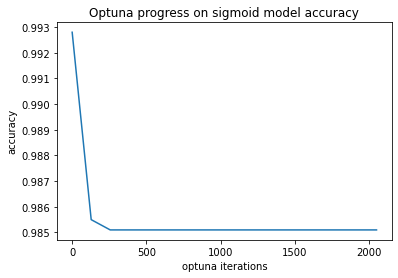

base-model accuracy:0.9941
2048-optuna-iterations-model accuracy:0.9866
difference:0.0075


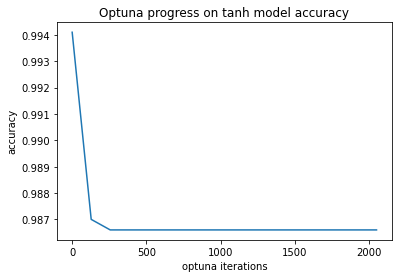

base-model accuracy:0.9931
2048-optuna-iterations-model accuracy:0.9832
difference:0.0099


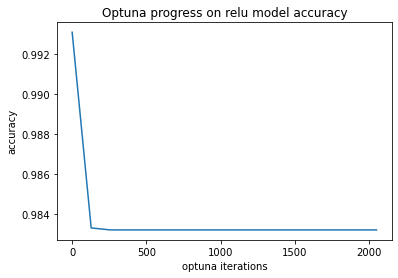

base-model accuracy:0.9934
2048-optuna-iterations-model accuracy:0.9846
difference:0.0088


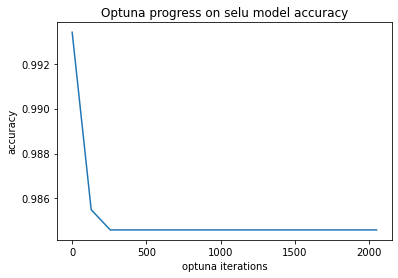

base-model accuracy:0.9943
2048-optuna-iterations-model accuracy:0.9882
difference:0.0061


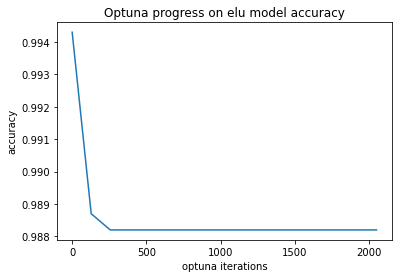

base-model accuracy:0.9909
2048-optuna-iterations-model accuracy:0.9811
difference:0.0098


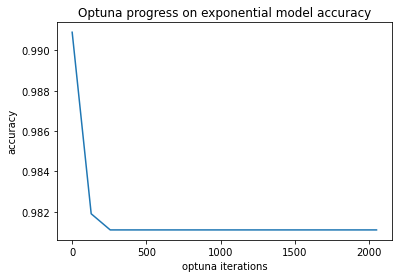

base-model accuracy:0.9932
2048-optuna-iterations-model accuracy:0.9843
difference:0.0089


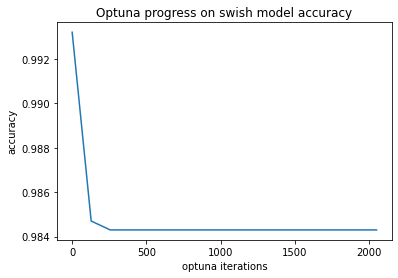

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    d = load_object(f"./scores/acc_trend_{function}")
    keys = np.fromiter(d.keys(), dtype=int)
    vals = np.fromiter(d.values(), dtype=float)
    print(f"base-model accuracy:{vals[0]}\n2048-optuna-iterations-model accuracy:{vals[-1]}\ndifference:%.4f" % (vals[0]-vals[-1]))

    plt.plot(keys, vals, label = "line 1")
    plt.title(f'Optuna progress on {function} model accuracy')
    plt.xlabel('optuna iterations')
    plt.ylabel('accuracy')
    plt.show()

#### Best attack for each function

index=9444 value=0.9230203628540039


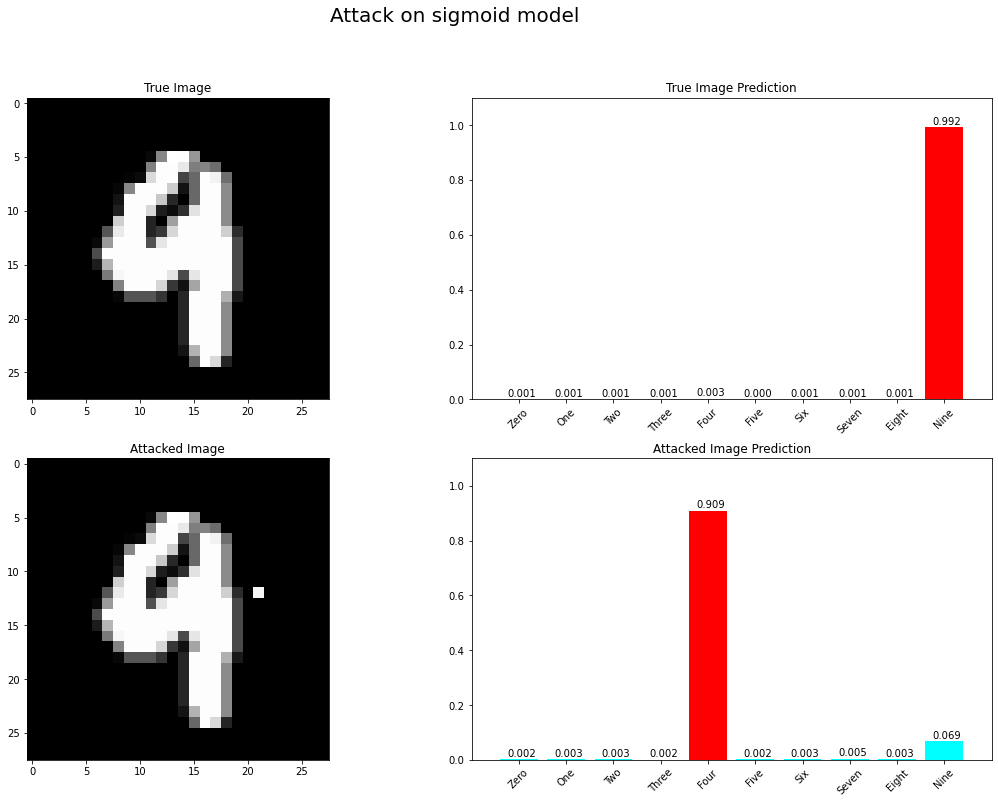

index=2867 value=0.984259843826294


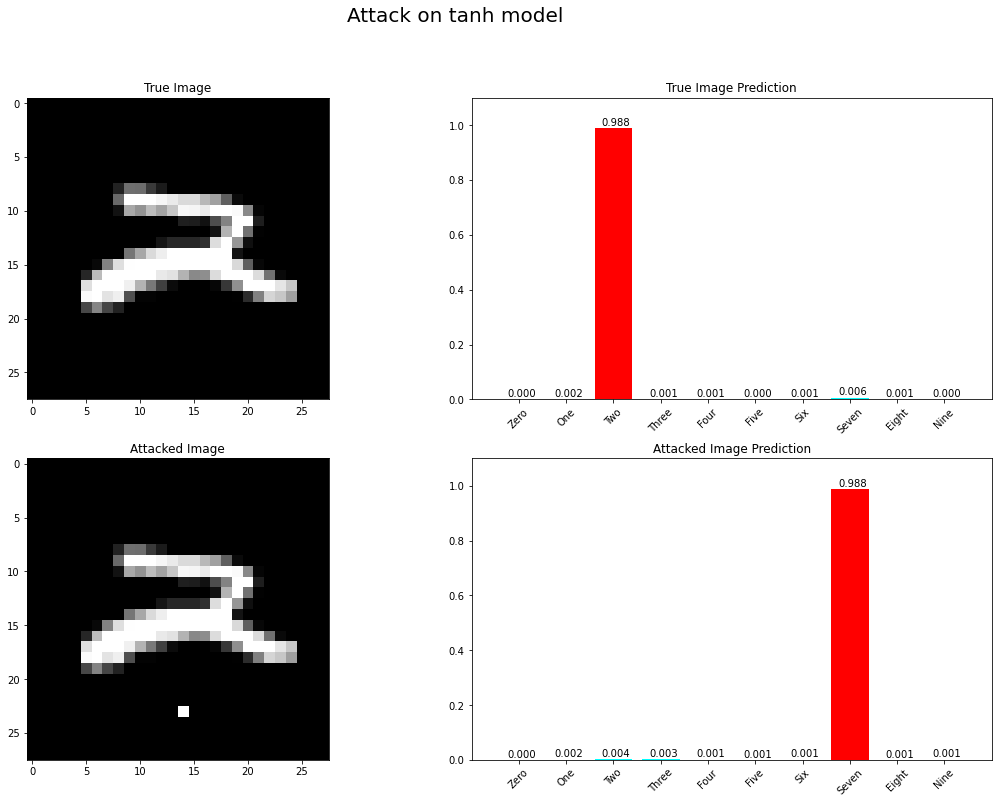

index=3478 value=0.9763248562812805


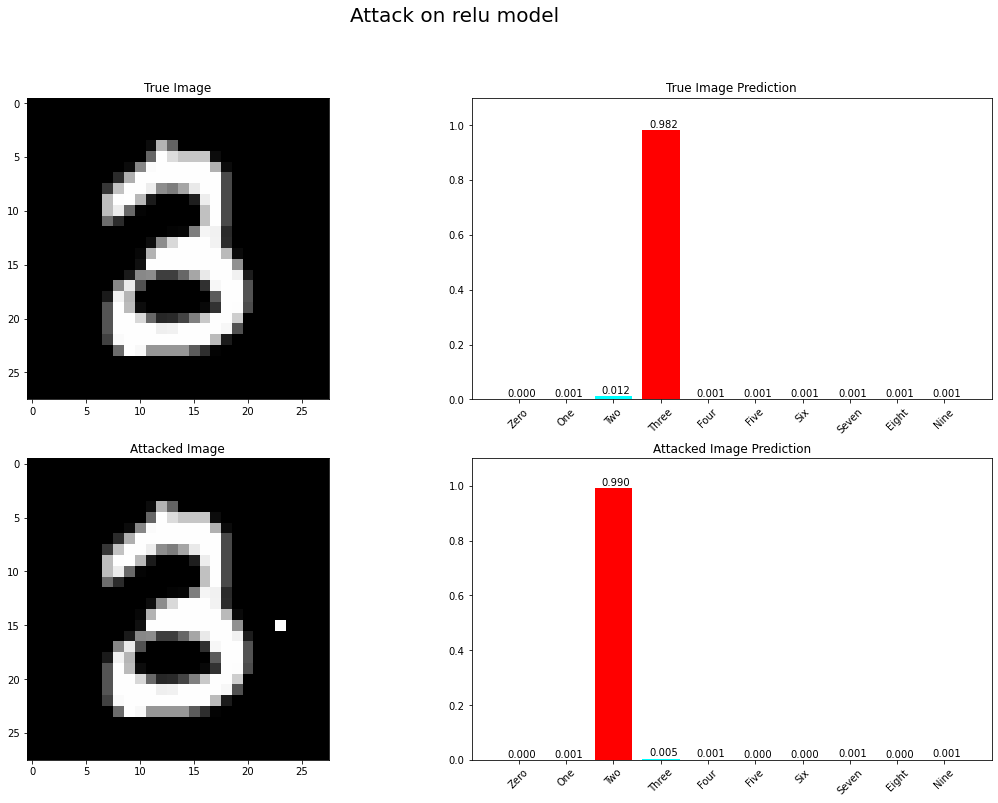

index=2967 value=0.983030378818512


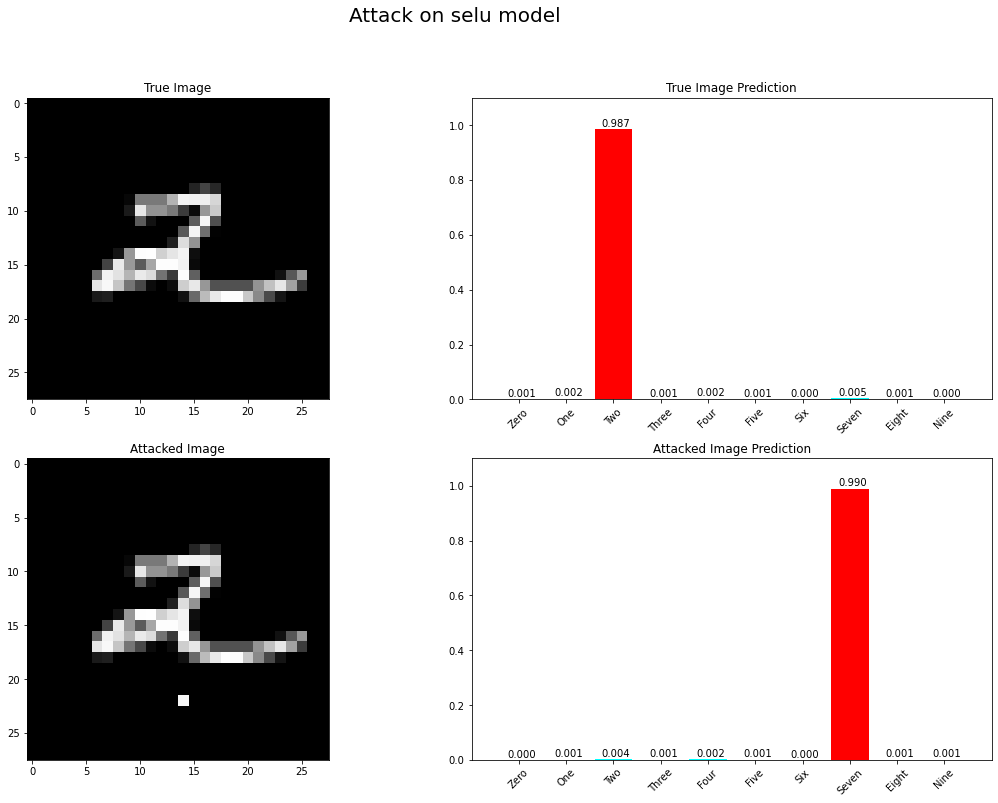

index=2589 value=0.9403399229049683


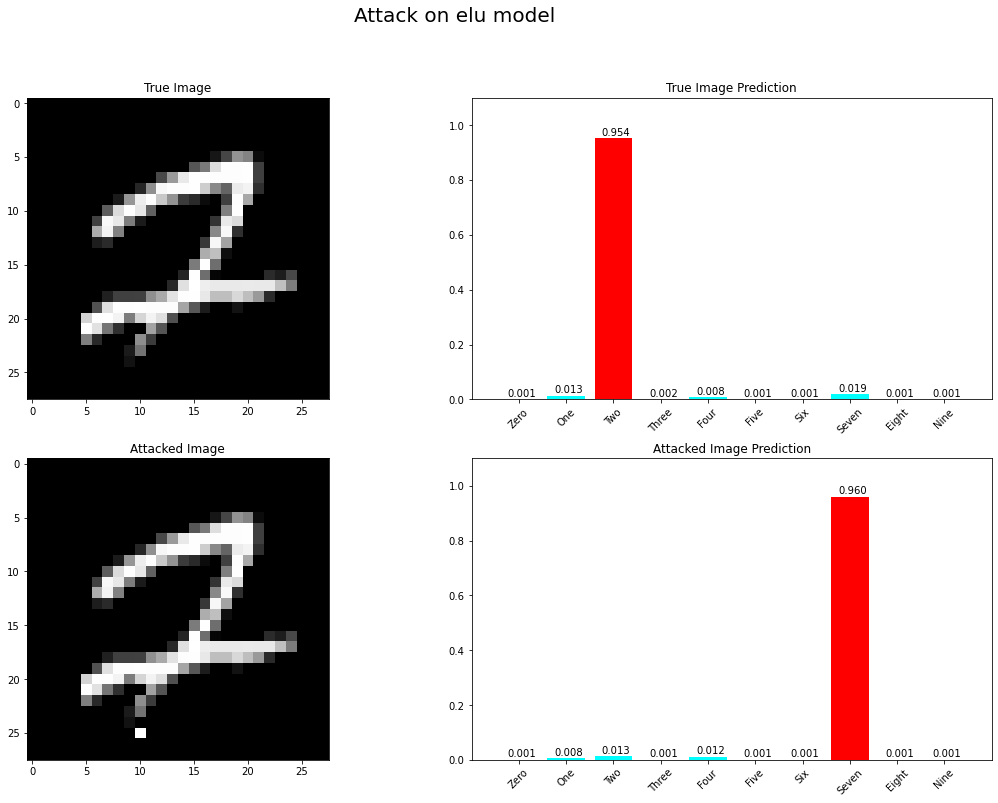

index=4255 value=0.9897226095199585


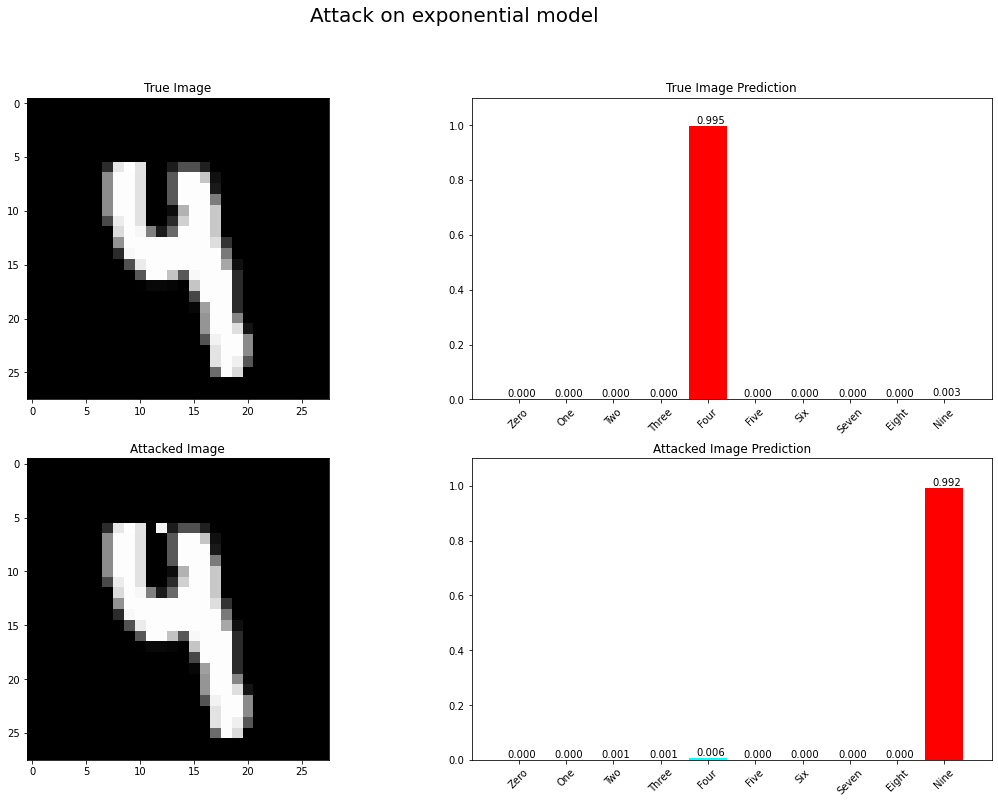

index=1205 value=0.9380684494972229


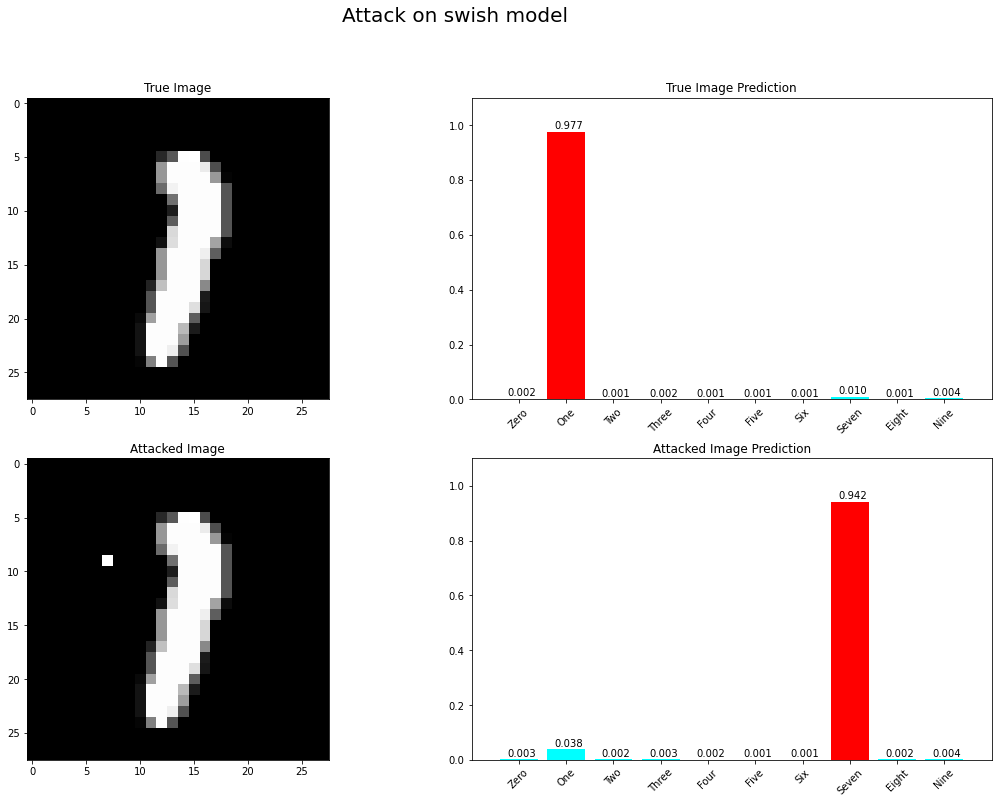

In [3]:
for function, initializer in DEEP_ACTIVATION.items():
    m1 = load_object(SCORES_PATH+"/scores_best_"+function)
    m2 = load_object(SCORES_PATH+"/scores_best_"+function+"_best_attack")
    m = load_model(MODELS_PATH+"/best_"+function+".h5")
    best_attack = 0
    maximum = 0
    for i in range (len(m1.y_true)): # per ogni immagine
        j = np.nonzero(m1.y_true[i])[0][0] # predizione vera
        k = abs(m1.y_pred[i][j] - m2.y_pred[i][j])
        if k >= maximum:
            maximum = k
            best_attack = i

    print(f"index={best_attack} value={maximum}")
    plot_attack(m1.x_test[best_attack], m2.x_test[best_attack], m, function)